In [1]:
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import c
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm
import numpy as np
from lf_utils import *
from GalGroup import *

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [2]:
hdul = fits.open(r"E:\PhD\Jon\GAMA data\TilingCatv46.fits")
data = hdul[1].data
t=Table(data)
df = t.to_pandas()

hdul2 = fits.open(r"E:\PhD\Jon\GAMA data\ApMatchedCatv06.fits")
data2 = hdul2[1].data
t2=Table(data2)
df2 = t2.to_pandas()

hdul3 = fits.open(r"E:\PhD\Jon\GAMA data\GalacticExtinctionv03.fits")
data3 = hdul3[1].data
t3=Table(data3)
df3 = t3.to_pandas()

In [3]:
df = pd.merge(df, df2[['CATAID', 'FLUX_AUTO_u', 'FLUX_AUTO_g', 'FLUX_AUTO_r', 'FLUX_AUTO_i', 'FLUX_AUTO_z', 'FLUXERR_AUTO_u', 'FLUXERR_AUTO_g', 'FLUXERR_AUTO_r', 'FLUXERR_AUTO_i', 'FLUXERR_AUTO_z']], on='CATAID', how='left')
df = pd.merge(df, df2[['CATAID', 'MAG_AUTO_u', 'MAG_AUTO_g', 'MAG_AUTO_r', 'MAG_AUTO_i', 'MAG_AUTO_z']], on='CATAID', how='left')
df = pd.merge(df, df3[['CATAID', 'A_u', 'A_g', 'A_r', 'A_i', 'A_z']], on='CATAID', how='left')

In [4]:
df = add_column(df, column_file = r"E:\PhD\Jon\GAMA data\DistancesFramesv14.fits", column_name = 'Z_CMB', common_column = 'CATAID')

In [5]:
df = df[(df['SURVEY_CLASS']>=4)]
df = calc_z_comp(df, search_radius=1.0, NQ_col='NQ', z_col='Z_CMB', ra_col='RA', dec_col='DEC', H0=100, Om0=0.25, Ode0=0.75)
df = df[(df['NQ']>=3) & (df['Z_CMB']>0.003) & (df['Z_CMB']<0.6) & (df['R_PETRO']<19.8)]

Calculating completeness:   0%|          | 0/188314 [00:00<?, ?it/s]

In [6]:
df['FLUX_AUTO_u'] = df['FLUX_AUTO_u'] * 10**(0.4 * df['A_u'])
df['FLUX_AUTO_g'] = df['FLUX_AUTO_g'] * 10**(0.4 * df['A_g'])
df['FLUX_AUTO_r'] = df['FLUX_AUTO_r'] * 10**(0.4 * df['A_r'])
df['FLUX_AUTO_i'] = df['FLUX_AUTO_i'] * 10**(0.4 * df['A_i'])
df['FLUX_AUTO_z'] = df['FLUX_AUTO_z'] * 10**(0.4 * df['A_z'])
df['MAG_AUTO_u'] = df['MAG_AUTO_u'] - df['A_u']
df['MAG_AUTO_g'] = df['MAG_AUTO_g'] - df['A_g']
df['MAG_AUTO_r'] = df['MAG_AUTO_r'] - df['A_r']
df['MAG_AUTO_i'] = df['MAG_AUTO_i'] - df['A_i']
df['MAG_AUTO_z'] = df['MAG_AUTO_z'] - df['A_z']

In [7]:
df

,CATAID,OBJID,RA,DEC,FIBERMAG_R,R_PETRO,U_MODEL,G_MODEL,R_MODEL,I_MODEL,...,MAG_AUTO_r,MAG_AUTO_i,MAG_AUTO_z,A_u,A_g,A_r,A_i,A_z,Z_CMB,z_comp
0,585589,588848899914203328,183.480648,-0.158225,19.985600,19.453074,21.894562,20.529739,19.453663,18.945805,...,19.437849,18.961590,18.622931,0.10653,0.07839,0.05685,0.04311,0.03057,0.184803,1.000000
1,585591,588848899914203338,183.497895,-0.167664,18.726801,17.603594,19.758217,18.387272,17.655390,17.203344,...,17.608940,17.182009,16.999689,0.10599,0.07799,0.05656,0.04289,0.03041,0.125614,0.987500
3,585592,588848899914203383,183.462863,-0.084334,19.729465,18.439117,21.375816,19.530548,18.330122,17.764397,...,18.388321,17.927290,17.447010,0.10210,0.07512,0.05448,0.04131,0.02929,0.180388,0.971429
4,585597,588848899914203421,183.459417,-0.147435,20.720388,19.627613,21.248838,20.511686,19.509012,19.120184,...,19.587139,19.183729,19.142620,0.10692,0.07867,0.05706,0.04327,0.03068,0.438662,1.000000
6,585600,588848899914203456,183.428237,-0.024423,20.539886,19.335196,20.904034,19.648397,19.229986,18.944212,...,19.297522,18.953030,18.800451,0.09778,0.07195,0.05218,0.03957,0.02805,0.123741,0.983333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221366,585568,588848899914137824,183.355331,-0.161464,19.925093,18.819307,20.849813,19.561117,18.809334,18.452356,...,18.755831,18.374910,18.189970,0.10920,0.08035,0.05827,0.04419,0.03133,0.126025,1.000000
221368,585576,588848899914137896,183.346806,-0.172458,20.530943,19.687235,21.441959,20.567142,19.603834,19.201668,...,19.656830,19.183020,19.030270,0.10918,0.08034,0.05827,0.04418,0.03133,0.324489,1.000000
221369,585577,588848899914137903,183.389071,-0.029114,20.450537,19.387207,20.815376,19.913673,19.304747,19.085520,...,19.366360,19.139040,18.821020,0.09752,0.07176,0.05204,0.03946,0.02798,0.202304,0.966667
221370,585574,588848899914137839,183.415321,-0.207848,19.690861,18.615723,22.564413,20.321875,18.613150,18.036314,...,18.638329,18.075680,17.735771,0.11200,0.08241,0.05977,0.04532,0.03213,0.321785,1.000000


Fixed  6227 missing fluxes
Replacing 321 bad fits with mean


c:\Users\adrie\Code\Jon current work\kcorr.py:71: RuntimeWarning: divide by zero encountered in power
  plt.errorbar(range(len(fnames)), flux_mean, yerr=ivar_mean**-0.5, color=color)


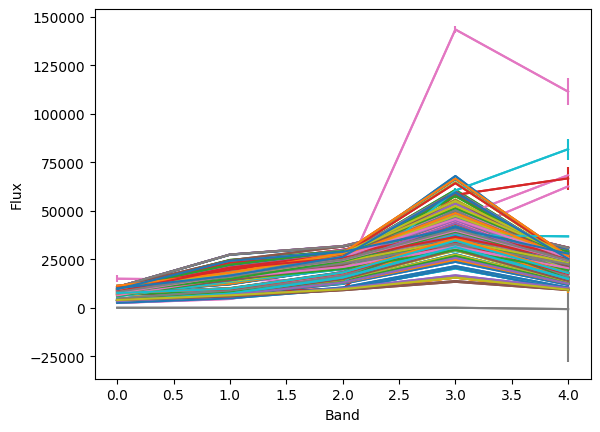

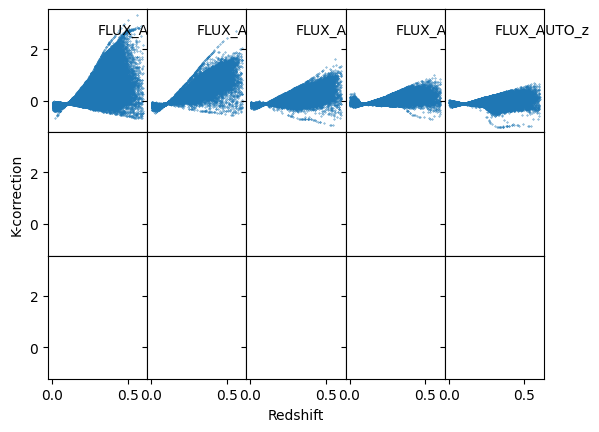

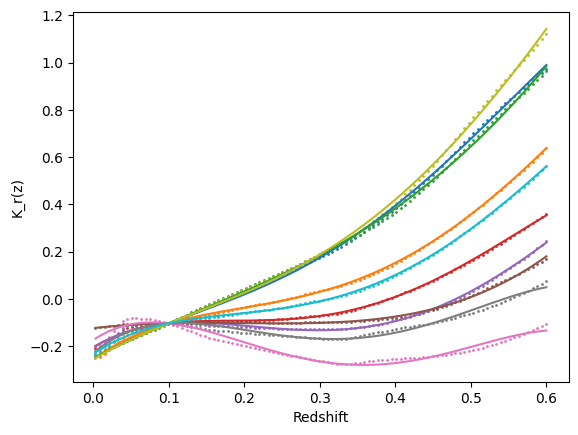

In [8]:
df = kcorrection(df, zrange = [0.003, 0.6], z0 = 0.1, 
                 responses = ['sdss_u0', 'sdss_g0', 'sdss_r0', 'sdss_i0', 'sdss_z0'], 
                 fnames = ['FLUX_AUTO_u', 'FLUX_AUTO_g', 'FLUX_AUTO_r', 'FLUX_AUTO_i', 'FLUX_AUTO_z'], 
                 ferrnames = ['FLUXERR_AUTO_u', 'FLUXERR_AUTO_g', 'FLUXERR_AUTO_r', 'FLUXERR_AUTO_i', 'FLUXERR_AUTO_z'], 
                 ref_index = 2, avg_index = 4, redshift = 'Z_CMB', survey='GAMAII')

In [9]:
df = luminosity_distance(df, redshift='Z_CMB', H0=100, Om0=0.25, Ode0=0.75)
df['AbMag'] = df['MAG_AUTO_r'] - 5 * np.log10(df['Lum_Distance']) + 5 - df['r_Kcorrection']

In [10]:
df

,CATAID,OBJID,RA,DEC,FIBERMAG_R,R_PETRO,U_MODEL,G_MODEL,R_MODEL,I_MODEL,...,A_i,A_z,Z_CMB,z_comp,Kcorrection,r_Kcorrection,pcoeffs,coeffs,Lum_Distance,AbMag
0,585589,588848899914203328,183.480648,-0.158225,19.985600,19.453074,21.894562,20.529739,19.453663,18.945805,...,0.04311,0.03057,0.184803,1.000000,"[0.06165177375078201, 0.20073693990707397, 0.0...",0.011254,"[[-0.1034817128955627, 2.0293624563187485, 0.5...","[1012217.5, 498.36279296875, 0.0, 4617017.5, 0.0]",6.326174e+08,-19.579111
1,585591,588848899914203338,183.497895,-0.167664,18.726801,17.603594,19.758217,18.387272,17.655390,17.203344,...,0.04289,0.03041,0.125614,0.987500,"[-0.046054936945438385, -0.0318424366414547, -...",-0.083315,"[[-0.1034817128955627, 2.8001991167283915, 0.3...","[5726658.0, 754.9407958984375, 1840321.625, 90...",4.135704e+08,-20.390492
2,585592,588848899914203383,183.462863,-0.084334,19.729465,18.439117,21.375816,19.530548,18.330122,17.764397,...,0.04131,0.02929,0.180388,0.971429,"[0.09619392454624176, 0.18427303433418274, 0.0...",0.017272,"[[-0.1034817128955627, 2.447625923786338, 4.10...","[4166042.75, 0.0, 0.0, 9154116.0, 181989.421875]",6.157742e+08,-20.576058
3,585597,588848899914203421,183.459417,-0.147435,20.720388,19.627613,21.248838,20.511686,19.509012,19.120184,...,0.04327,0.03068,0.438662,1.000000,"[0.07503938674926758, 0.6183409094810486, 0.06...",0.060789,"[[-0.1034817128955627, 1.2061213209527903, -1....","[0.0, 740.784912109375, 322769.03125, 2175906....",1.723157e+09,-21.655273
4,585600,588848899914203456,183.428237,-0.024423,20.539886,19.335196,20.904034,19.648397,19.229986,18.944212,...,0.03957,0.02805,0.123741,0.983333,"[-0.07614395767450333, -0.059619925916194916, ...",-0.105598,"[[-0.1034817128955627, 1.6701499781145654, -1....","[511064.125, 242.3717498779297, 589794.5, 0.0,...",4.068838e+08,-18.644232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182239,585568,588848899914137824,183.355331,-0.161464,19.925093,18.819307,20.849813,19.561117,18.809334,18.452356,...,0.04419,0.03133,0.126025,1.000000,"[-0.03706793487071991, -0.021554844453930855, ...",-0.080506,"[[-0.1034817128955627, 3.003343397994448, 2.97...","[175737.140625, 347.3005676269531, 338731.5937...",4.150408e+08,-19.254117
182240,585576,588848899914137896,183.346806,-0.172458,20.530943,19.687235,21.441959,20.567142,19.603834,19.201668,...,0.04418,0.03133,0.324489,1.000000,"[0.08064594864845276, 0.4209232032299042, 0.09...",0.094187,"[[-0.1034817128955627, 0.9688745573459878, 0.2...","[305073.03125, 635.6768798828125, 0.0, 3819744...",1.204508e+09,-20.841405
182241,585577,588848899914137903,183.389071,-0.029114,20.450537,19.387207,20.815376,19.913673,19.304747,19.085520,...,0.03946,0.02798,0.202304,0.966667,"[0.007437344174832106, 0.10120141506195068, -0...",-0.072826,"[[-0.1034817128955627, 1.02322086229994, 2.036...","[0.0, 0.0, 117334.0859375, 1947195.75, 207364....",7.001526e+08,-19.786778
182242,585574,588848899914137839,183.415321,-0.207848,19.690861,18.615723,22.564413,20.321875,18.613150,18.036314,...,0.04532,0.03213,0.321785,1.000000,"[1.5221028327941895, 0.9134882688522339, 0.230...",0.230861,"[[-0.1034817128955627, 4.866301274218437, 14.7...","[295620.5625, 0.0, 0.0, 14323335.0, 0.0]",1.192757e+09,-21.975292


In [11]:
df.to_pickle(r"E:\PhD\Jon\pickle datafiles\GAMAII_group_gals_dataframe.pkl")

In [12]:
# import pandas as pd
# df = pd.read_pickle(r"E:\PhD\Jon\pickle datafiles\GAMAII_group_gals_dataframe.pkl")
# from GalGroup import *

# import warnings
# warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [ ]:
df, groups = find_groups(df, mlims=(0, 19.8), Mlims=(-24, -12), m_col='MAG_AUTO_r', M_col='AbMag', z_col='Z_CMB', ra_col='RA', dec_col='DEC', 
                         velerr_col='VEL_ERR', z_comp_col='z_comp', galid_col = 'CATAID', 
                         H0=100, Om0=0.25, Ode0=0.75, M_star=-20.71, alpha=-1.26, phi=10**(-2.02), 
                         delta=9, r_delta=1.5, l_delta=12, b0=0.06, R0=18, E_b=-0.00, E_r=-0.02, nu=0.63, A=10.0, B=1.04)

5199 galaxies filtered out
Processing 177045 galaxies ...
Calculating mean comoving galaxy separation and comoving radial distance ...


  0%|          | 0/177045 [00:00<?, ?it/s]

184 galaxies had their D_lim value clipped at 100 Mpc
Calculating mean required linking overdensity and radial expansion factor ...


0it [00:00, ?it/s]

  0%|          | 0/177045 [00:00<?, ?it/s]

Finding groups ...


  0%|          | 0/177045 [00:00<?, ?it/s]

In [14]:
df

,CATAID,OBJID,RA,DEC,FIBERMAG_R,R_PETRO,U_MODEL,G_MODEL,R_MODEL,I_MODEL,...,D_lim,D_com,rho_bar,rho_emp,b,R,b_comp,anglink,loslink,GroupID
0,610842,588848900450353796,181.825627,0.403123,21.116133,19.727045,21.037203,19.858603,19.680634,19.589466,...,100.000000,340.336274,3.666746e-12,0.235785,0.06,11.433854,0.060000,0.017628,68.603124,1
1,84104,587722983885832250,176.019050,0.450443,19.406237,18.296717,20.507496,18.979570,18.274017,24.308266,...,100.000000,408.335060,1.893771e-11,0.047157,0.06,12.202055,0.060000,0.014693,73.212330,2
2,594479,588848899930325063,220.294994,-0.134271,17.939005,17.258764,20.089510,17.356993,17.039074,16.280821,...,96.097029,411.382757,1.909559e-10,0.070736,0.06,12.676030,0.060000,0.014015,73.087730,3
3,3588815,587729150377197591,136.425233,-1.741611,18.461533,17.066629,21.055769,19.060587,17.148270,16.891754,...,100.000000,456.056588,1.747751e-11,0.141471,0.06,11.917731,0.060451,0.013254,72.044051,4
4,3605090,587729150912167949,132.063749,-1.202615,19.199530,17.961416,19.557970,18.812384,18.001154,17.755100,...,100.000000,476.984676,1.134425e-11,0.058946,0.06,12.023855,0.060000,0.012578,72.143132,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177040,3602341,587729150911513009,130.572401,-1.165690,20.622314,19.763655,20.844343,20.236860,19.757648,19.811893,...,6.104177,790.840605,9.806554e-05,0.023579,0.06,16.855334,0.060000,0.000463,6.173277,22327
177041,116411,587724648717746366,174.526820,-2.956637,20.252529,19.707647,20.075972,19.855082,19.660959,19.696709,...,5.535707,717.522299,1.573790e-04,0.011789,0.06,17.253077,0.060000,0.000463,5.730479,0
177042,709415,587725075526844719,134.454762,0.423364,20.153536,19.768839,20.432888,20.079107,19.725471,19.818373,...,6.135482,796.864082,9.561281e-05,0.058946,0.06,16.540878,0.060000,0.000462,6.089176,0
177043,260790,587726015619662125,211.751299,2.509174,20.387289,19.767742,20.544949,20.102516,19.679255,19.661070,...,5.519433,717.492363,1.596011e-04,0.011789,0.06,17.257916,0.060000,0.000462,5.715235,0


In [15]:
groups

,GroupID,N,GalCen,RA,Dec,z,vel_disp,rad50,dyn_mass,lum,Gals,GalCenID,Gals_id
0,1,119,0,181.825627,0.403123,0.116131,1715.316719,2.169596,1.484248e+16,1.165645e+12,"{0, 64000, 71170, 44546, 41473, 93708, 95761, ...",610842,"[610842, 85288, 70810, 70804, 8308, 70891, 852..."
1,2,31,1,176.019050,0.450443,0.140016,1725.904178,2.147775,1.487514e+16,5.941559e+11,"{1, 46343, 119567, 37648, 87314, 88722, 105106...",84104,"[84104, 7140, 69729, 7210, 69654, 69714, 7228,..."
2,3,86,2,220.294994,-0.134271,0.141092,1421.687707,2.112812,9.929060e+15,1.451731e+12,"{2, 109058, 78338, 6153, 67599, 107026, 71188,...",594479,"[594479, 79067, 594613, 594542, 64842, 594366,..."
3,4,45,3,136.425233,-1.741611,0.156927,565.555129,1.787708,1.329491e+15,8.204597e+11,"{3, 135300, 59525, 102279, 92682, 19230, 93472...",3588815,"[3588815, 3589347, 3865414, 3866176, 3613176, ..."
4,5,66,4,132.063749,-1.202615,0.164384,2100.609548,2.521137,2.586581e+16,1.497824e+12,"{137346, 4, 152582, 35976, 97800, 135562, 1459...",3605090,"[3605283, 3605090, 3580949, 3605195, 3603978, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23993,23994,2,175553,180.035592,1.430757,0.238392,14.811931,0.145738,7.434232e+10,2.667850e+10,"{175553, 176485}",272597,"[272597, 272613]"
23994,23995,2,177014,134.620134,1.638540,0.262440,45.096796,0.165979,7.848428e+11,3.499639e+10,"{175937, 177014}",324172,"[324161, 324172]"
23995,23996,2,175950,136.429087,-1.973100,0.221746,0.000000,0.015700,0.000000e+00,1.959421e+10,"{176532, 175950}",3865746,"[3865747, 3865746]"
23996,23997,2,176285,184.884951,1.809194,0.267262,110.449621,0.017680,5.014641e+11,3.835720e+10,"{176786, 176285}",290158,"[290157, 290158]"


In [16]:
len(df[df['GroupID']==0])/len(df)

0.5605354570871812

In [17]:
print(f"Number of ungrouped galaxies : {len(df[df['GroupID']==0])}, ie. {round(100 * len(df[df['GroupID']==0])/len(df), 2)}%")
print(f"Number of galaxies with local redshift completeness > 95% : {len(df[df['z_comp']>0.95])}")
print(f"Number of groups with more than 5 members : {len(groups[groups['N']>5])}")
print(f"Number of groups with velocity dispersion = 0 (ie. error > value) : {len(groups[groups['vel_disp']==0])}")
print(f"Number of groups with velocity dispersion > 2500 km.s^-1 : {len(groups[groups['vel_disp']>2500])}")

Number of ungrouped galaxies : 99240, ie. 56.05%
Number of galaxies with local redshift completeness > 95% : 166438
Number of groups with more than 5 members : 2056
Number of groups with velocity dispersion = 0 (ie. error > value) : 2074
Number of groups with velocity dispersion > 2500 km.s^-1 : 29


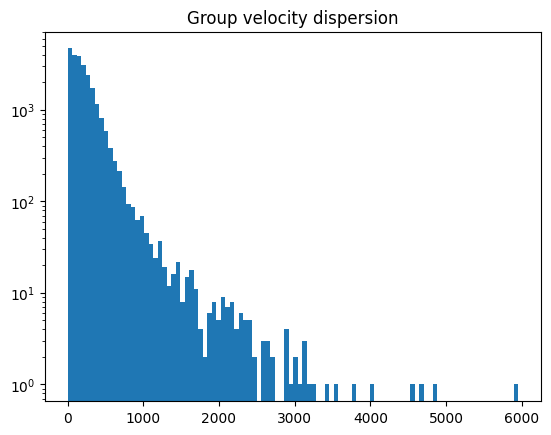

In [18]:
plt.hist(groups['vel_disp'], bins=100)
plt.yscale('log')
plt.title('Group velocity dispersion')
plt.show()

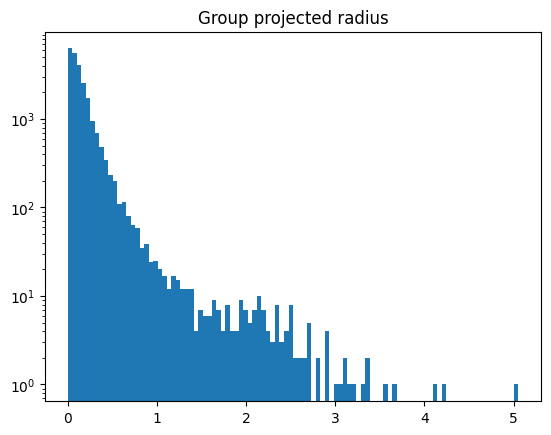

In [19]:
plt.hist(groups['rad50'], bins=100)
plt.yscale('log')
plt.title('Group projected radius')
plt.show()

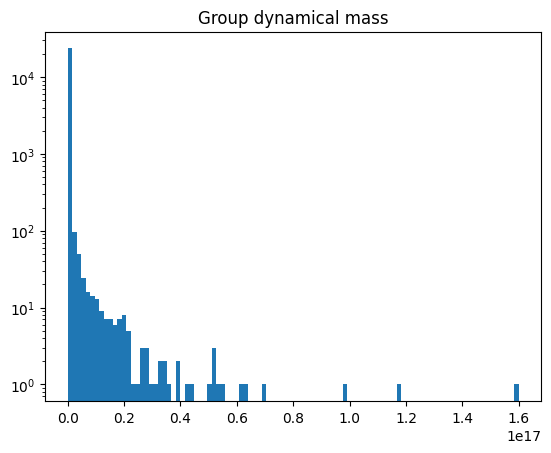

In [20]:
plt.hist(groups['dyn_mass'], bins=100)
plt.yscale('log')
plt.title('Group dynamical mass')
plt.show()

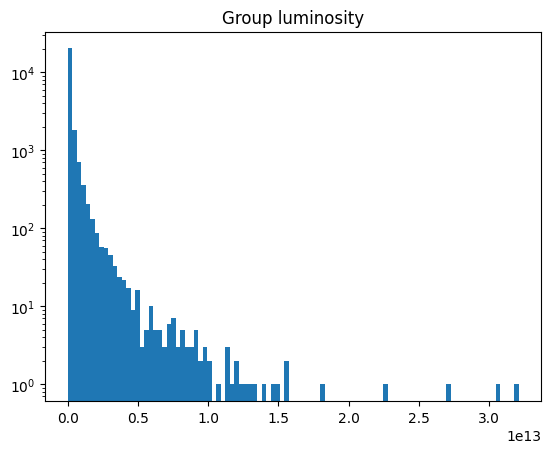

In [21]:
plt.hist(groups['lum'], bins=100)
plt.yscale('log')
plt.title('Group luminosity')
plt.show()

In [22]:
groups[groups['vel_disp']>2500]

,GroupID,N,GalCen,RA,Dec,z,vel_disp,rad50,dyn_mass,lum,Gals,GalCenID,Gals_id
10,11,19,10,135.106581,-1.438547,0.208182,3076.715900,2.356679,5.186974e+16,1.108472e+12,"{91779, 10, 14, 122008, 45339, 80555, 146098, ...",3884312,"[3610667, 3884312, 3862593, 3610812, 3884936, ..."
40,41,40,8485,216.841199,0.945528,0.291854,2700.126373,3.109657,5.271323e+16,3.328706e+12,"{133131, 120461, 99213, 85518, 17040, 107409, ...",106619,"[106595, 106709, 106609, 278256, 106695, 22828..."
43,44,5,65,212.966847,-1.852697,0.309787,2689.898276,2.514166,4.229651e+16,1.341330e+12,"{65, 52199, 56905, 3307, 64145}",484850,"[484850, 484884, 484831, 484821, 460605]"
67,68,7,111,222.752653,0.025437,0.362269,2605.446999,1.734329,2.737378e+16,2.713467e+12,"{97507, 14949, 63078, 111, 112, 82357, 94653}",79727,"[594982, 79668, 79698, 79727, 79697, 747048, 7..."
115,116,14,205,130.867814,-0.580407,0.428271,2566.972778,3.381677,5.181000e+16,9.244547e+12,"{39456, 517, 19785, 14762, 9772, 205, 5101, 29...",549215,"[549335, 549265, 196440, 196381, 549253, 54921..."
125,126,10,228,212.831389,1.748143,0.444843,3121.525940,1.947071,4.411178e+16,9.044807e+12,"{33922, 7140, 228, 28166, 8231, 12474, 1770, 3...",237979,"[237930, 318917, 237979, 318919, 238019, 23795..."
147,148,2,278,135.850393,1.715789,0.484856,3272.439316,0.163209,4.063745e+15,4.150704e+12,"{21130, 278}",324412,"[324431, 324412]"
166,167,3,322,138.935581,-0.455600,0.512184,2926.565331,3.121448,6.216007e+16,7.158276e+12,"{322, 3276, 21812}",551122,"[551122, 551120, 551085]"
180,181,2,345,129.846890,-0.802470,0.559720,3775.277138,1.175982,3.897060e+16,1.289171e+13,"{2328, 345}",3896286,"[3622228, 3896286]"
183,184,2,353,221.975966,-0.955459,0.527070,3999.064181,1.339464,4.980658e+16,8.865957e+12,"{353, 478}",545953,"[545953, 513166]"


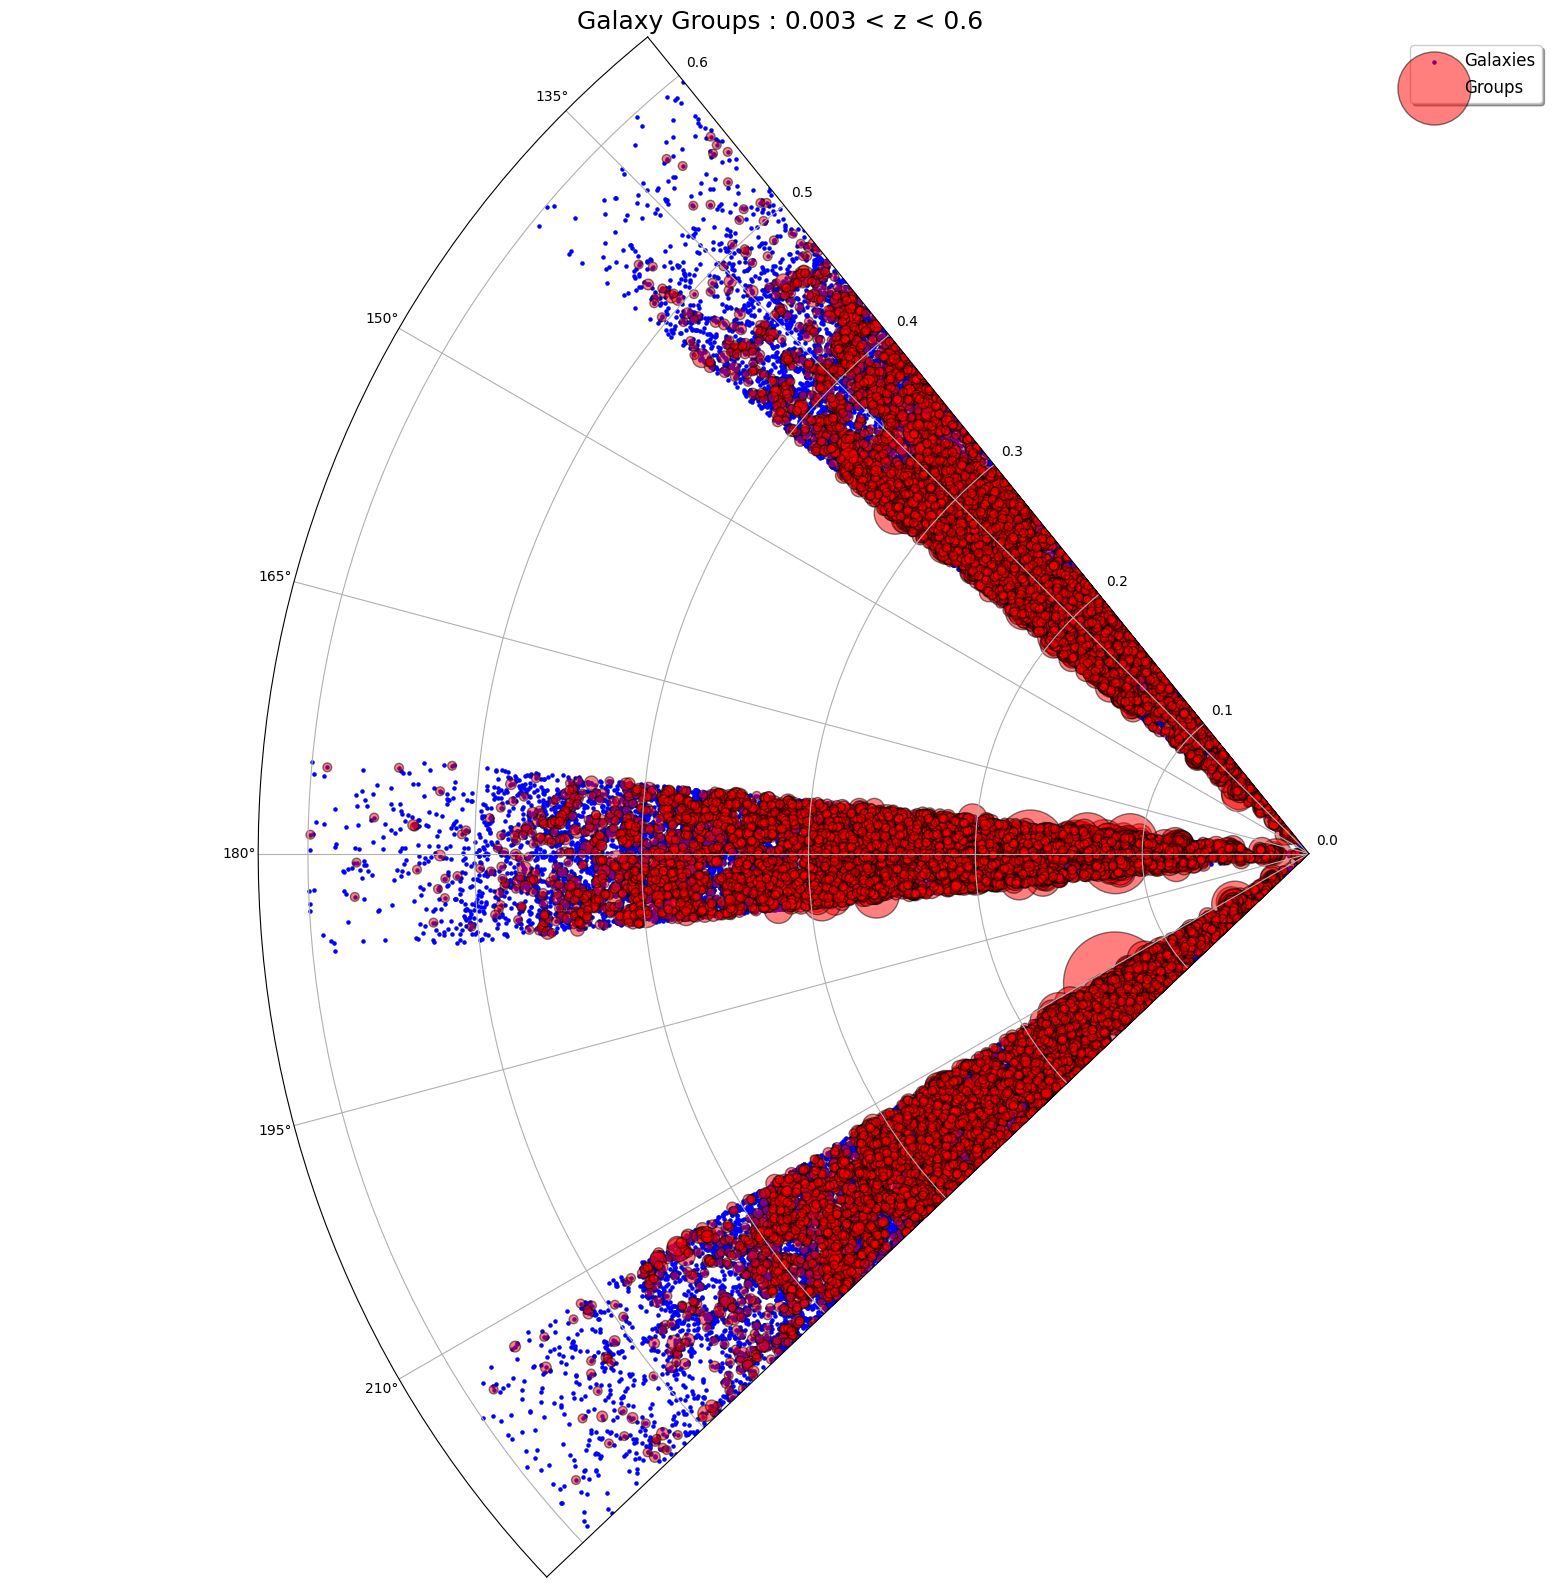

In [23]:
plot_galaxy_groups(df, groups, gal_ra_col='RA', gal_z_col='Z_CMB', zmin=0.003, zmax=0.6)

### Comparison with GAMA II official groups (Robotham et al. 2011, https://www.gama-survey.org/dr4/schema/dmu.php?id=115)

In [24]:
hdul4 = fits.open(r"E:\PhD\Jon\GAMA data\G3CGalv10.fits")
data4 = hdul4[1].data
t4=Table(data4)
robgals = t4.to_pandas()

hdul5 = fits.open(r"E:\PhD\Jon\GAMA data\G3CFoFGroupv10.fits")
data5 = hdul5[1].data
t5=Table(data5)
robgroups = t5.to_pandas()

In [25]:
robgals = robgals[robgals['RA'] > 100]
robgals

,CATAID,RA,Dec,Z,Rpetro,DM_100_25_75,SURVEY_CODE,SigErr,GroupID,RankIterCen,...,CoSepIterCen,AngSepIterCen,RankBCG,SepBCG,CoSepBCG,AngSepBCG,RankCen,SepCen,CoSepCen,AngSepCen
0,6802,174.005984,0.720935,0.051814,18.622816,36.044518,5,24.158697,0,-999,...,-999.000000,-999.000000,-999,-999.000000,-999.000000,-999.000000,-999,-999.000000,-999.000000,-999.000000
1,6803,174.021648,0.754885,0.161697,19.219088,38.683414,5,40.067787,0,-999,...,-999.000000,-999.000000,-999,-999.000000,-999.000000,-999.000000,-999,-999.000000,-999.000000,-999.000000
2,6804,174.092055,0.674096,0.220298,19.341200,39.434891,5,24.125309,0,-999,...,-999.000000,-999.000000,-999,-999.000000,-999.000000,-999.000000,-999,-999.000000,-999.000000,-999.000000
3,6805,174.022355,0.702532,0.334006,19.301096,40.477726,5,58.761257,203003,2,...,0.056042,0.042028,2,12.394894,0.056042,0.042028,2,8.251231,0.037307,0.027978
4,6806,174.022807,0.705945,0.332854,18.544878,40.468914,5,24.662685,203003,1,...,0.000000,0.000000,1,0.000000,0.000000,0.000000,1,4.143663,0.018735,0.014050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184076,4220443,181.699980,-1.981059,0.254122,19.383205,39.788528,5,69.031700,0,-999,...,-999.000000,-999.000000,-999,-999.000000,-999.000000,-999.000000,-999,-999.000000,-999.000000,-999.000000
184077,4265516,129.750133,0.061317,0.205135,18.858145,39.259930,5,38.587601,103220,1,...,0.000000,0.000000,1,0.000000,0.000000,0.000000,1,6.411320,0.018377,0.015244
184078,4310456,181.327902,1.447848,0.243260,19.625502,39.679916,5,24.820072,0,-999,...,-999.000000,-999.000000,-999,-999.000000,-999.000000,-999.000000,-999,-999.000000,-999.000000,-999.000000
184079,4331410,130.281567,-0.116788,0.295070,19.516560,40.163151,5,54.553314,0,-999,...,-999.000000,-999.000000,-999,-999.000000,-999.000000,-999.000000,-999,-999.000000,-999.000000,-999.000000


In [26]:
robgroups = robgroups[robgroups['IterCenRA'] > 100]
robgroups

,GroupID,Nfof,IterCenCATAID,IterCenRA,IterCenDec,IterCenZ,Zfof,Rad50,Rad1Sig,Rad100,...,LumBfunc,d3vol,d3area,d2radec,d2raz,d2decz,distortcirc,distortellip,distortsph,URL_IMG
0,100001,62,622475,133.652530,0.642573,0.108074,0.108044,0.350337,0.511327,0.723547,...,5.707738e+11,13.453133,67.206726,0.982322,19.432892,22.070499,1.044060,1.147736,2.456856,http://www.gama-survey.org/dr4/data/files/Grou...
1,100002,59,599753,132.599724,0.260119,0.197270,0.197310,0.475004,0.583933,1.592990,...,7.532606e+11,13.879583,63.516598,1.464789,15.836410,25.748030,1.316447,1.324571,2.274148,http://www.gama-survey.org/dr4/data/files/Grou...
2,100003,76,575146,138.519864,-0.023528,0.167690,0.167680,1.071943,1.818537,3.015239,...,9.775184e+11,18.082594,70.801666,2.141497,16.040085,29.723379,1.258020,1.329273,2.125130,http://www.gama-survey.org/dr4/data/files/Grou...
3,100004,37,549404,131.435402,-0.488043,0.156034,0.156474,0.267129,0.302825,0.627853,...,4.435979e+11,3.328334,24.334095,0.521852,7.228287,8.428942,1.095464,1.274427,2.257251,http://www.gama-survey.org/dr4/data/files/Grou...
4,100005,34,387173,135.502599,2.393273,0.202819,0.202638,0.457391,0.611274,1.019182,...,4.437586e+11,8.139059,42.717434,0.900930,15.201762,12.295998,1.093525,1.199399,2.183090,http://www.gama-survey.org/dr4/data/files/Grou...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23649,307998,2,620034,222.942829,0.289828,0.043451,0.043666,0.019098,0.025973,0.038195,...,9.630856e+09,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,http://www.gama-survey.org/dr4/data/files/Grou...
23650,307999,2,620059,223.041019,0.350269,0.147972,0.147731,0.088744,0.120691,0.177487,...,1.408043e+10,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,http://www.gama-survey.org/dr4/data/files/Grou...
23651,308000,2,620080,222.997497,0.283705,0.423385,0.425047,0.256407,0.348713,0.512814,...,1.623469e+11,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,http://www.gama-survey.org/dr4/data/files/Grou...
23652,308001,2,620161,223.496208,0.348077,0.260180,0.259970,0.069907,0.095074,0.139815,...,1.755114e+10,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,http://www.gama-survey.org/dr4/data/files/Grou...


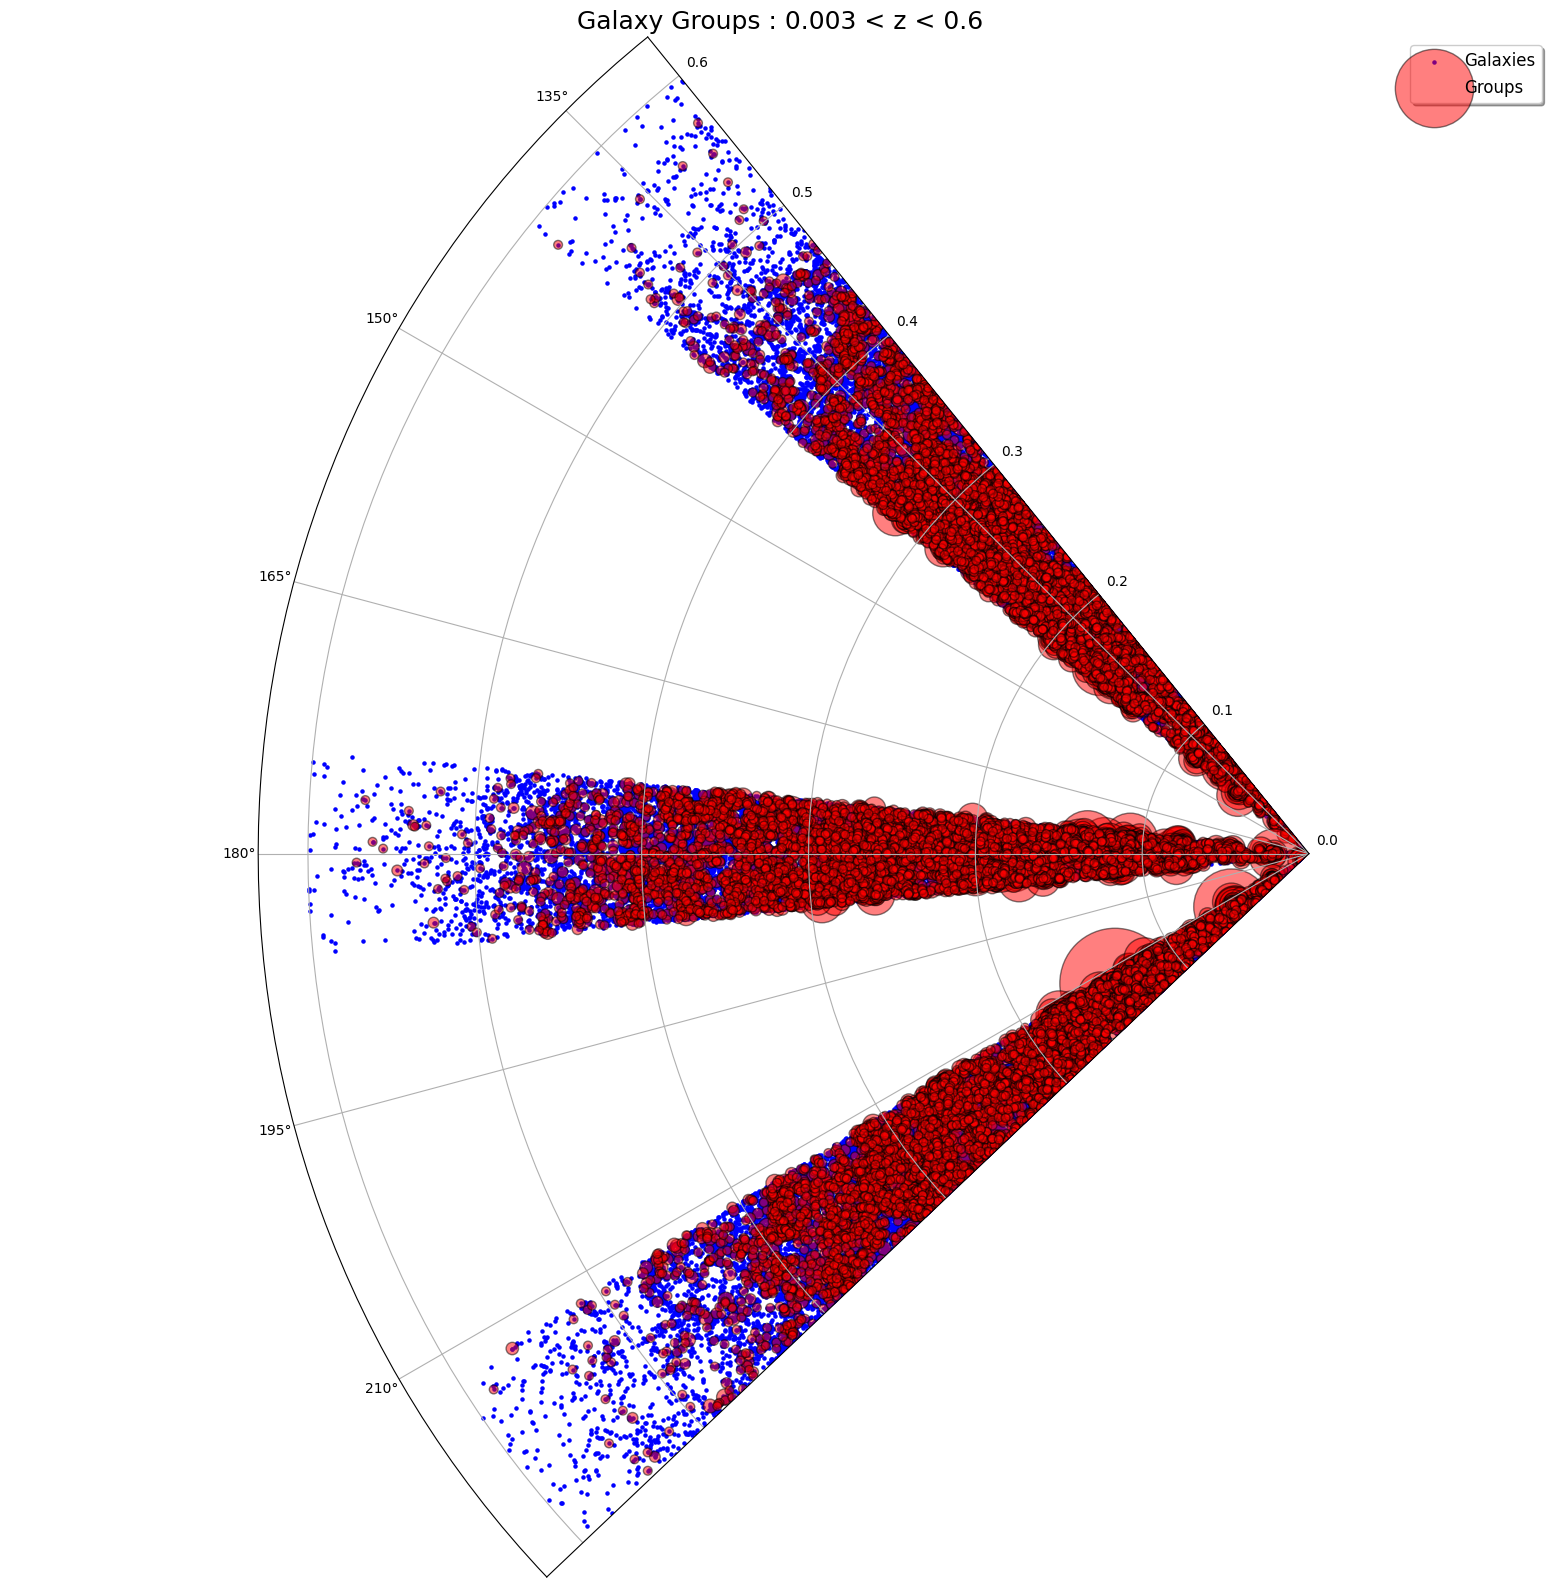

In [27]:
plot_galaxy_groups(robgals, robgroups, gal_ra_col='RA', gal_z_col='Z', group_ra_col='IterCenRA' , group_z_col='IterCenZ', group_N_col='Nfof', zmin=0.003, zmax=0.6)

In [28]:
print(f"Number of groups in common with Robotham : {len(pd.Series(list(set(groups['GalCenID']) & set(robgroups['IterCenCATAID']))))}, ie. {round(100 * len(pd.Series(list(set(groups['GalCenID']) & set(robgroups['IterCenCATAID']))))/len(robgroups), 2)}% of the Robotham groups")

Number of groups in common with Robotham : 19930, ie. 84.26% of the Robotham groups


In [29]:
dfme = groups[groups['GalCenID'].isin(set(groups['GalCenID']) & set(robgroups['IterCenCATAID']))].sort_values(by='GalCenID')
dfrob = robgroups[robgroups['IterCenCATAID'].isin(set(groups['GalCenID']) & set(robgroups['IterCenCATAID']))].sort_values(by='IterCenCATAID')

dfme5 = groups[groups['N'] >= 5][groups[groups['N'] >= 5]['GalCenID'].isin(set(groups[groups['N'] >= 5]['GalCenID']) & set(robgroups[robgroups['Nfof'] >= 5]['IterCenCATAID']))].sort_values(by='GalCenID')
dfrob5 = robgroups[robgroups['Nfof'] >= 5][robgroups[robgroups['Nfof'] >= 5]['IterCenCATAID'].isin(set(groups[groups['N'] >= 5]['GalCenID']) & set(robgroups[robgroups['Nfof'] >= 5]['IterCenCATAID']))].sort_values(by='IterCenCATAID')

In [30]:
print(f"Number of groups with 5 or more members in common with Robotham : {len(dfme5)}, ie. {round(100 * len(dfrob5)/len(robgroups[robgroups['Nfof'] >= 5]), 2)}% of the Robotham groups")

Number of groups with 5 or more members in common with Robotham : 2179, ie. 79.12% of the Robotham groups


In [31]:
dfme

,GroupID,N,GalCen,RA,Dec,z,vel_disp,rad50,dyn_mass,lum,Gals,GalCenID,Gals_id
8230,8231,2,27794,174.022807,0.705945,0.332854,321.476219,0.028066,6.743909e+12,2.538560e+11,"{27794, 94987}",6806,"[6806, 6805]"
20412,20413,2,105598,174.100731,0.658922,0.230851,133.636013,0.011051,4.588694e+11,4.538981e+10,"{168817, 105598}",6808,"[6809, 6808]"
13843,13844,2,55688,174.109090,0.803909,0.327908,357.735239,0.107678,3.203966e+13,1.935464e+11,"{55688, 105405}",6810,"[6810, 6811]"
14395,14396,2,58756,174.150221,0.675395,0.313851,218.820653,0.023523,2.618866e+12,1.599359e+11,"{123105, 58756}",6827,"[6828, 6827]"
7198,7199,2,23942,174.302787,0.789993,0.075612,84.157829,0.005446,8.968145e+10,5.241525e+09,"{30189, 23942}",6837,"[6838, 6837]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,1146,3,3089,139.977026,-1.272340,0.027079,44.335145,0.002271,1.037988e+10,5.092282e+08,"{3736, 3089, 3855}",3913787,"[3913741, 3913787, 3913786]"
5142,5143,2,16554,139.970278,-1.257093,0.361721,79.529089,0.063910,9.398522e+11,3.806293e+11,"{16554, 87511}",3913823,"[3913823, 3913810]"
17844,17845,4,82717,138.769534,-0.877684,0.296643,495.268024,0.284928,1.625007e+14,2.247271e+11,"{84923, 82717, 149863, 125543}",3914033,"[527718, 3914033, 527729, 3914041]"
7564,7565,2,25283,139.580504,-0.914533,0.143840,225.724850,0.036727,4.350898e+12,5.487532e+10,"{25283, 36861}",3914237,"[3914237, 3914211]"


In [32]:
dfrob

,GroupID,Nfof,IterCenCATAID,IterCenRA,IterCenDec,IterCenZ,Zfof,Rad50,Rad1Sig,Rad100,...,LumBfunc,d3vol,d3area,d2radec,d2raz,d2decz,distortcirc,distortellip,distortsph,URL_IMG
10483,203003,2,6806,174.022807,0.705945,0.332854,0.333430,0.028021,0.038108,0.056042,...,6.616092e+10,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,http://www.gama-survey.org/dr4/data/files/Grou...
10484,203004,2,6808,174.100731,0.658922,0.230851,0.230615,0.011057,0.015037,0.022114,...,1.732158e+10,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,http://www.gama-survey.org/dr4/data/files/Grou...
10485,203005,2,6810,174.109090,0.803909,0.327908,0.328543,0.107485,0.146180,0.214970,...,4.002295e+10,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,http://www.gama-survey.org/dr4/data/files/Grou...
10486,203006,2,6827,174.150221,0.675395,0.313851,0.314241,0.023496,0.031955,0.046992,...,3.602987e+10,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,http://www.gama-survey.org/dr4/data/files/Grou...
10487,203007,2,6837,174.302787,0.789993,0.075612,0.075737,0.005435,0.007392,0.010871,...,5.144671e+09,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,http://www.gama-survey.org/dr4/data/files/Grou...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2806,102807,3,3913787,139.977026,-1.272340,0.027079,0.027079,0.002270,0.038788,0.103710,...,1.014881e+09,-999.000000,-999.000000,0.000082,0.002804,0.001684,6.197139,-999.000000,-999.000000,http://www.gama-survey.org/dr4/data/files/Grou...
7478,107479,2,3913823,139.970278,-1.257093,0.361721,0.361555,0.063937,0.086954,0.127874,...,6.545585e+10,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,http://www.gama-survey.org/dr4/data/files/Grou...
2227,102228,4,3914033,138.769534,-0.877684,0.296643,0.298285,0.284305,0.440440,0.454964,...,7.557295e+10,0.011993,1.182169,0.036039,0.429722,0.304051,1.434938,4.303986,4.665502,http://www.gama-survey.org/dr4/data/files/Grou...
7479,107480,2,3914237,139.580504,-0.914533,0.143840,0.144190,0.036640,0.049831,0.073280,...,3.177657e+10,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,http://www.gama-survey.org/dr4/data/files/Grou...


In [33]:
dfme5

,GroupID,N,GalCen,RA,Dec,z,vel_disp,rad50,dyn_mass,lum,Gals,GalCenID,Gals_id
1822,1823,13,5226,174.924700,0.762383,0.358903,647.487875,0.616096,6.005517e+14,2.309594e+12,"{60992, 51621, 55273, 5226, 13964, 128780, 116...",6934,"[6932, 97885, 97838, 6934, 6922, 6923, 6935, 6..."
1548,1549,22,4446,175.347288,0.633636,0.311314,574.098923,0.408172,3.127922e+14,2.154920e+12,"{26781, 34214, 73006, 35762, 86323, 141495, 10...",7043,"[7049, 7045, 6998, 83951, 83964, 7064, 83976, ..."
2746,2747,12,8045,175.553578,0.632872,0.307869,521.574719,0.414900,2.624310e+14,1.239027e+12,"{73828, 116324, 107909, 45704, 143307, 8045, 1...",7079,"[7085, 84017, 7081, 7088, 84016, 7079, 7080, 7..."
1368,1369,11,3839,175.671730,0.717860,0.304234,537.619578,0.715726,4.809899e+14,9.482262e+11,"{86153, 99210, 83699, 66228, 125653, 50616, 69...",7102,"[7090, 7113, 7110, 7109, 7114, 7112, 7116, 712..."
3055,3056,9,9100,177.151973,0.781294,0.127425,455.363411,0.047909,2.309804e+13,1.206595e+11,"{84833, 49411, 9100, 29453, 51502, 97112, 6575...",7369,"[7375, 7370, 7369, 7377, 7371, 7373, 7372, 738..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6766,6767,8,22378,138.658581,-1.305661,0.283850,373.774168,0.542906,1.763529e+14,5.887710e+11,"{73219, 169576, 22378, 51498, 112143, 135000, ...",3911772,"[3616190, 3911844, 3911772, 3911771, 3911776, ..."
2553,2554,5,7414,138.862190,-1.311257,0.282501,442.578442,0.674733,3.072920e+14,3.255702e+11,"{176306, 148118, 7414, 78329, 157727}",3911945,"[3616680, 3616521, 3911945, 3616652, 3912272]"
6264,6265,6,20669,138.867091,-1.302325,0.104120,212.874075,0.045875,4.833490e+12,4.770958e+10,"{30820, 59111, 43795, 57466, 43132, 20669}",3911985,"[3911899, 3911946, 3911990, 3912013, 3911960, ..."
8339,8340,8,28277,139.162679,-1.249627,0.299022,255.202356,0.267314,4.047899e+13,5.324115e+11,"{146791, 131625, 110365, 28277, 110522, 92219,...",3912498,"[3912595, 3912585, 3912580, 3912498, 3912593, ..."


In [34]:
dfrob5

,GroupID,Nfof,IterCenCATAID,IterCenRA,IterCenDec,IterCenZ,Zfof,Rad50,Rad1Sig,Rad100,...,LumBfunc,d3vol,d3area,d2radec,d2raz,d2decz,distortcirc,distortellip,distortsph,URL_IMG
7685,200205,14,6934,174.924700,0.762383,0.358903,0.355183,0.631445,0.676151,1.637186,...,6.135303e+11,4.240567,28.624456,0.873766,7.258950,10.413315,1.199338,1.441680,2.259283,http://www.gama-survey.org/dr4/data/files/Grou...
7507,200027,24,7043,175.347288,0.633636,0.311314,0.311234,0.432254,0.813439,1.433293,...,7.562653e+11,6.934162,38.244682,1.085132,13.860801,9.676198,1.234368,1.308753,2.174825,http://www.gama-survey.org/dr4/data/files/Grou...
7639,200159,12,7079,175.553578,0.632872,0.307869,0.311954,0.413939,0.576508,0.870002,...,3.758124e+11,1.537586,15.220654,0.429449,4.692646,5.252984,1.171036,1.591813,2.362597,http://www.gama-survey.org/dr4/data/files/Grou...
7686,200206,8,7102,175.671730,0.717860,0.304234,0.306326,0.485402,0.677451,0.881016,...,2.570013e+11,1.555800,15.438401,0.519321,3.664337,5.718873,1.228956,1.595073,2.377656,http://www.gama-survey.org/dr4/data/files/Grou...
7687,200207,9,7369,177.151973,0.781294,0.127425,0.127425,0.047625,0.095252,0.323477,...,1.002868e+11,0.175542,4.987329,0.055957,1.481097,1.653514,1.216622,1.586373,3.289501,http://www.gama-survey.org/dr4/data/files/Grou...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,100749,6,3911772,138.658581,-1.305661,0.283850,0.283118,0.509051,0.575950,1.010116,...,1.618046e+11,0.065871,3.063916,0.223518,0.969179,1.072450,1.163612,5.504468,3.884450,http://www.gama-survey.org/dr4/data/files/Grou...
2609,102610,5,3911945,138.862190,-1.311257,0.282501,0.282501,0.673748,0.712011,0.745613,...,1.115892e+11,0.138729,3.873915,0.237204,0.800335,1.550406,1.229567,2.941830,2.989203,http://www.gama-survey.org/dr4/data/files/Grou...
315,100316,7,3911985,138.867091,-1.302325,0.104120,0.104240,0.049569,0.095884,0.196546,...,4.847186e+10,0.015580,1.045571,0.013739,0.353322,0.336495,1.179395,1.951392,3.465949,http://www.gama-survey.org/dr4/data/files/Grou...
231,100232,9,3912498,139.162679,-1.249627,0.299022,0.298842,0.270667,0.347895,0.517431,...,1.849329e+11,0.230504,4.541242,0.149763,1.411644,1.471615,1.215683,1.820317,2.497877,http://www.gama-survey.org/dr4/data/files/Grou...


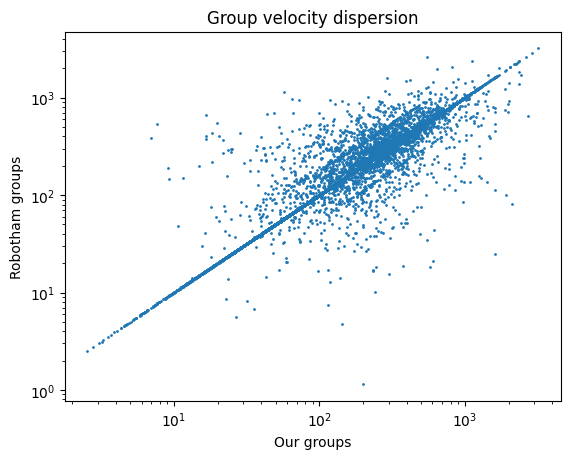

In [35]:
plt.scatter(dfme['vel_disp'], dfrob['VelDisp'], s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Our groups')
plt.ylabel('Robotham groups')
plt.title('Group velocity dispersion')
plt.show()

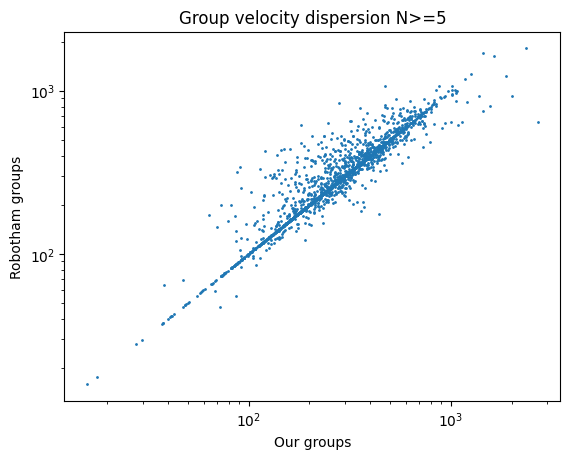

In [36]:
plt.scatter(dfme5['vel_disp'], dfrob5['VelDisp'], s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Our groups')
plt.ylabel('Robotham groups')
plt.title('Group velocity dispersion N>=5')
plt.show()

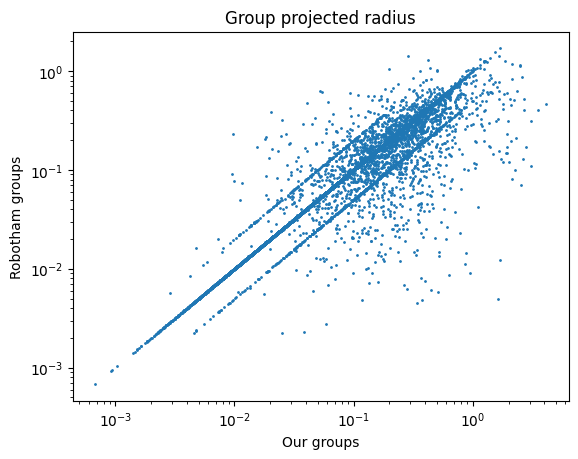

In [37]:
plt.scatter(dfme['rad50'], dfrob['Rad50'], s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Our groups')
plt.ylabel('Robotham groups')
plt.title('Group projected radius')
plt.show()

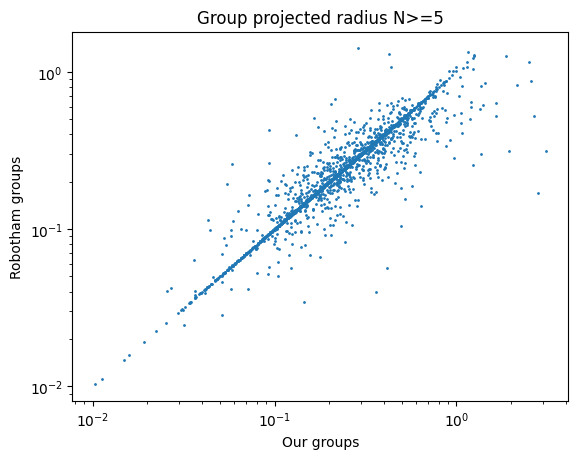

In [38]:
plt.scatter(dfme5['rad50'], dfrob5['Rad50'], s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Our groups')
plt.ylabel('Robotham groups')
plt.title('Group projected radius N>=5')
plt.show()

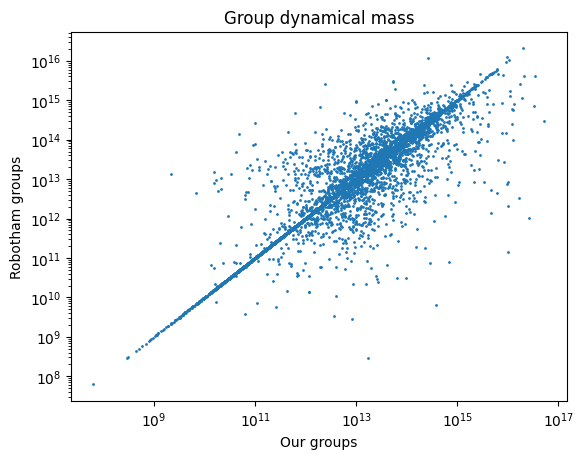

In [39]:
plt.scatter(dfme['dyn_mass'], dfrob['MassA'], s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Our groups')
plt.ylabel('Robotham groups')
plt.title('Group dynamical mass')
plt.show()

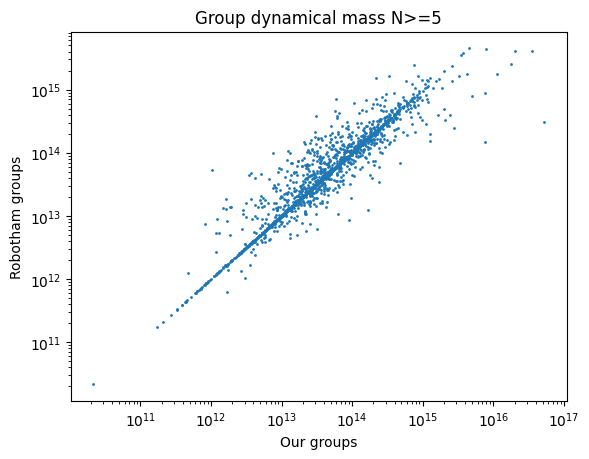

In [40]:
plt.scatter(dfme5['dyn_mass'], dfrob5['MassA'], s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Our groups')
plt.ylabel('Robotham groups')
plt.title('Group dynamical mass N>=5')
plt.show()

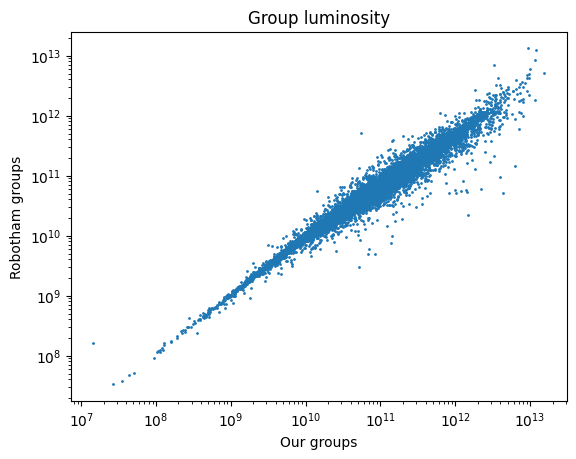

In [41]:
plt.scatter(dfme['lum'], dfrob['LumB'], s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Our groups')
plt.ylabel('Robotham groups')
plt.title('Group luminosity')
plt.show()

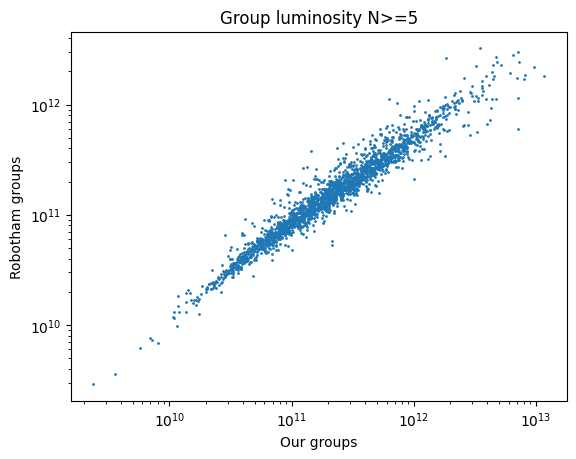

In [42]:
plt.scatter(dfme5['lum'], dfrob5['LumB'], s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Our groups')
plt.ylabel('Robotham groups')
plt.title('Group luminosity N>=5')
plt.show()

### Method comparison with Robotham et al. 2011 to calculate velocity dispersion, projected radius and dynamical mass

In [43]:
cosmo = LambdaCDM(H0=100, Om0=0.25, Ode0=0.75)
robgals['v'] = robgals['Z'] * c.to(u.km / u.s).value
robgals['D_com'] = co_dist(robgals['Z'], cosmo)
veldisp = []
projrad = []
dynmass = []
for i in tqdm(robgroups['GroupID']):
    v_gals = np.array(robgals[robgals['GroupID']==i]['v'])
    v_gals_err = np.array(robgals[robgals['GroupID']==i]['SigErr'])
    z_group = np.array(robgroups[robgroups['GroupID']==i]['Zfof'])
    v_disp = velocity_dispersion(v_gals, v_gals_err, z_group)
    veldisp.append(v_disp)
    ra_gals = np.array(robgals[robgals['GroupID']==i]['RA'])
    dec_gals = np.array(robgals[robgals['GroupID']==i]['Dec'])
    ra_cen_gal = np.array(robgroups[robgroups['GroupID']==i]['IterCenRA'])
    dec_cen_gal = np.array(robgroups[robgroups['GroupID']==i]['IterCenDec'])
    dist_gals = np.array(robgals[robgals['GroupID']==i]['D_com'])
    rad50 = group_radius(ra_gals, dec_gals, ra_cen_gal, dec_cen_gal, dist_gals)
    projrad.append(rad50)
    dynmass.append(dynamical_mass(v_disp, rad50, 10.0))

robgroups['vel_disp'] = veldisp
robgroups['proj_rad'] = projrad
robgroups['dyn_mass'] = dynmass

  0%|          | 0/23654 [00:00<?, ?it/s]

In [44]:
robgals

,CATAID,RA,Dec,Z,Rpetro,DM_100_25_75,SURVEY_CODE,SigErr,GroupID,RankIterCen,...,RankBCG,SepBCG,CoSepBCG,AngSepBCG,RankCen,SepCen,CoSepCen,AngSepCen,v,D_com
0,6802,174.005984,0.720935,0.051814,18.622816,36.044518,5,24.158697,0,-999,...,-999,-999.000000,-999.000000,-999.000000,-999,-999.000000,-999.000000,-999.000000,15533.387695,153.803288
1,6803,174.021648,0.754885,0.161697,19.219088,38.683414,5,40.067787,0,-999,...,-999,-999.000000,-999.000000,-999.000000,-999,-999.000000,-999.000000,-999.000000,48475.472656,469.451714
2,6804,174.092055,0.674096,0.220298,19.341200,39.434891,5,24.125309,0,-999,...,-999,-999.000000,-999.000000,-999.000000,-999,-999.000000,-999.000000,-999.000000,66043.617188,631.703067
3,6805,174.022355,0.702532,0.334006,19.301096,40.477726,5,58.761257,203003,2,...,2,12.394894,0.056042,0.042028,2,8.251231,0.037307,0.027978,100132.390625,934.087117
4,6806,174.022807,0.705945,0.332854,18.544878,40.468914,5,24.662685,203003,1,...,1,0.000000,0.000000,0.000000,1,4.143663,0.018735,0.014050,99787.164062,931.107998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184076,4220443,181.699980,-1.981059,0.254122,19.383205,39.788528,5,69.031700,0,-999,...,-999,-999.000000,-999.000000,-999.000000,-999,-999.000000,-999.000000,-999.000000,76183.882812,723.377963
184077,4265516,129.750133,0.061317,0.205135,18.858145,39.259930,5,38.587601,103220,1,...,1,0.000000,0.000000,0.000000,1,6.411320,0.018377,0.015244,61497.781250,590.133364
184078,4310456,181.327902,1.447848,0.243260,19.625502,39.679916,5,24.820072,0,-999,...,-999,-999.000000,-999.000000,-999.000000,-999,-999.000000,-999.000000,-999.000000,72927.664062,694.098774
184079,4331410,130.281567,-0.116788,0.295070,19.516560,40.163151,5,54.553314,0,-999,...,-999,-999.000000,-999.000000,-999.000000,-999,-999.000000,-999.000000,-999.000000,88459.867188,832.409360


In [45]:
robgroups

,GroupID,Nfof,IterCenCATAID,IterCenRA,IterCenDec,IterCenZ,Zfof,Rad50,Rad1Sig,Rad100,...,d2radec,d2raz,d2decz,distortcirc,distortellip,distortsph,URL_IMG,vel_disp,proj_rad,dyn_mass
0,100001,62,622475,133.652530,0.642573,0.108074,0.108044,0.350337,0.511327,0.723547,...,0.982322,19.432892,22.070499,1.044060,1.147736,2.456856,http://www.gama-survey.org/dr4/data/files/Grou...,747.927413,0.349529,4.546124e+14
1,100002,59,599753,132.599724,0.260119,0.197270,0.197310,0.475004,0.583933,1.592990,...,1.464789,15.836410,25.748030,1.316447,1.324571,2.274148,http://www.gama-survey.org/dr4/data/files/Grou...,544.217724,0.479282,3.300468e+14
2,100003,76,575146,138.519864,-0.023528,0.167690,0.167680,1.071943,1.818537,3.015239,...,2.141497,16.040085,29.723379,1.258020,1.329273,2.125130,http://www.gama-survey.org/dr4/data/files/Grou...,410.792478,1.070177,4.198940e+14
3,100004,37,549404,131.435402,-0.488043,0.156034,0.156474,0.267129,0.302825,0.627853,...,0.521852,7.228287,8.428942,1.095464,1.274427,2.257251,http://www.gama-survey.org/dr4/data/files/Grou...,452.386597,0.272088,1.294694e+14
4,100005,34,387173,135.502599,2.393273,0.202819,0.202638,0.457391,0.611274,1.019182,...,0.900930,15.201762,12.295998,1.093525,1.199399,2.183090,http://www.gama-survey.org/dr4/data/files/Grou...,591.534575,0.462006,3.758779e+14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23649,307998,2,620034,222.942829,0.289828,0.043451,0.043666,0.019098,0.025973,0.038195,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,http://www.gama-survey.org/dr4/data/files/Grou...,152.739988,0.019191,1.040968e+12
23650,307999,2,620059,223.041019,0.350269,0.147972,0.147731,0.088744,0.120691,0.177487,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,http://www.gama-survey.org/dr4/data/files/Grou...,155.609589,0.088604,4.988427e+12
23651,308000,2,620080,222.997497,0.283705,0.423385,0.425047,0.256407,0.348713,0.512814,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,http://www.gama-survey.org/dr4/data/files/Grou...,874.019152,0.257310,4.570224e+14
23652,308001,2,620161,223.496208,0.348077,0.260180,0.259970,0.069907,0.095074,0.139815,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,http://www.gama-survey.org/dr4/data/files/Grou...,122.553164,0.069854,2.439380e+12


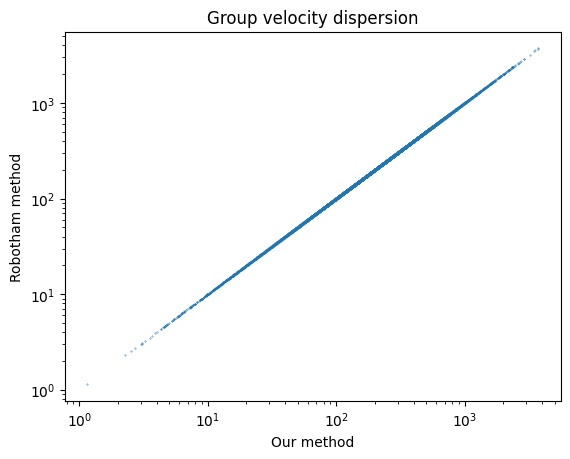

In [46]:
plt.scatter(robgroups['vel_disp'], robgroups['VelDisp'], s=0.1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Our method')
plt.ylabel('Robotham method')
plt.title('Group velocity dispersion')
plt.show()

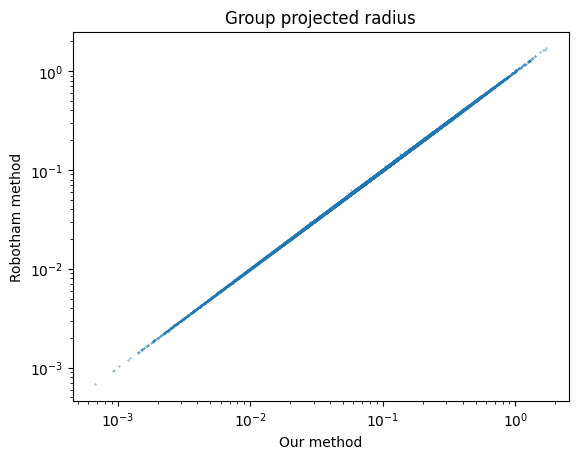

In [47]:
plt.scatter(robgroups['proj_rad'], robgroups['Rad50'], s=0.1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Our method')
plt.ylabel('Robotham method')
plt.title('Group projected radius')
plt.show()

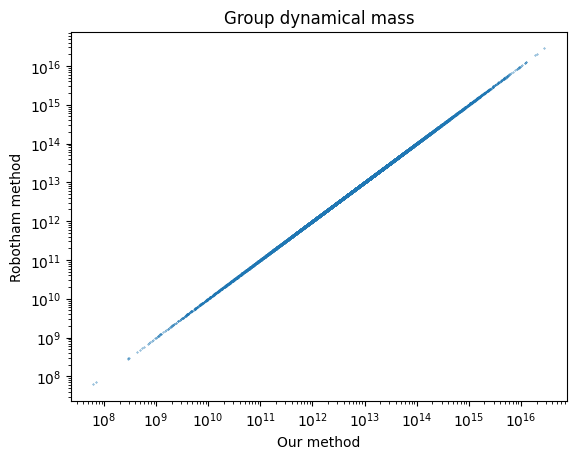

In [48]:
plt.scatter(robgroups['dyn_mass'], robgroups['MassA'], s=0.1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Our method')
plt.ylabel('Robotham method')
plt.title('Group dynamical mass')
plt.show()